In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import keras
import pandas as pd
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2
from sklearn.utils import shuffle

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# '/content/gdrive/My Drive/adversarial-xray/'
sys.path.append(ROOT_DIR)  
# import helpers

# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')

PATH = "{}/{}".format(DATASET, "dataNumpy")
# load data
x_train = np.load("{}/x_train.npy".format(PATH))
y_train = np.load("{}/y_train.npy".format(PATH))
x_train_gan = np.load("{}/x_train_gan.npy".format(PATH))     #normal, covid
y_train_gan = np.load("{}/y_train_gan.npy".format(PATH)) 
x_train_gan_p = np.load("{}/x_train_gan_p.npy".format(PATH)) #pneumonia, covid
y_train_gan_p = np.load("{}/y_train_gan_p.npy".format(PATH))

x_train.shape, y_train.shape
x_train_gan.shape, y_train_gan.shape
x_train_gan_p.shape, y_train_gan_p.shape

MODEL_PATH_n = os.path.join(ROOT_DIR, "models")   #normal
MODEL_PATH_p = os.path.join(ROOT_DIR, "models_p") #covid

print(ROOT_DIR)
print(os.listdir(MODEL_PATH_n))
print(os.listdir(MODEL_PATH_p))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

/content/gdrive/My Drive/adversarial-xray/
['images', 'record.csv', 'b2m.h5', 'm2b.h5', 'model.h5']
['images', 'record.csv', 'b2m.h5', 'm2b.h5', 'model.h5']


In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')


In [4]:
import sys
# !{sys.executable} -m pip install tensorflow==1.13.1
# keras==2.2.4
# !pip install git+https://www.github.com/keras-team/keras-contrib.git

%tensorflow_version 1.x

import tensorflow
import keras
print(tensorflow.__version__)
print(keras.__version__)

import tensorflow as tf
tf.test.gpu_device_name()


TensorFlow is already loaded. Please restart the runtime to change versions.
1.13.1
2.3.1


''

In [5]:
# Load translation model b2m.h5
model_name = 'b2m.h5'
model_n = load_model(os.path.join(MODEL_PATH_n, model_name), custom_objects={'InstanceNormalization':InstanceNormalization})
model_p = load_model(os.path.join(MODEL_PATH_p, model_name), custom_objects={'InstanceNormalization':InstanceNormalization})

model_n.summary()
model_p.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 128, 128, 32) 1568        input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, 128, 128, 32) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
instance_normalization_27 (Inst (None, 128, 128, 32) 2           leaky_re_lu_25[0][0]             
____________________________________________________________________________________________

In [0]:
def predict(model, img):
    
    if img.shape[0] != 256:
        print("Resizing image..")
        img = cv2.resize(img, (256, 256))
    
    # Normalize image as the trained distribution
    img = img/127.5 - 1.
    
    img = np.expand_dims(img, axis=0)
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    
    # Rescale to [0,1]
    img = (img - np.min(img))/np.ptp(img)
    return img


def oversample(x_n, y_n, x_p, y_p, x_c, y_c, model_n, model_p):
    
    print("Before oversampling :", x_c.shape, y_c.shape)
    
    ## FROM NORMAL TO COVID-19
    print("Generating covid-19 x-ray images from normal x-ray images....")
    # majority class
    majority_samples_n = []
    for img, label in zip(x_n, y_n):
        if label[0] == 1:
            # print(label, label[0])
            majority_samples_n.append(img)
        else:
            pass
    
    # numpy array of majority classes
    sample_needed = int((len(majority_samples_n)-175)/2)
    majority_samples_n = majority_samples_n [0:sample_needed]
    majority_samples_n = np.array(majority_samples_n)
   
    # minority generated samples
    synthetic_samples_n = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples_n):
        
        # translate to covid
        pred = predict(model_n, img)
        synthetic_samples_n.append(pred)
    

    ## FROM PNEUMONIA TO COVID-19
    print("\n\nGenerating covid-19 x-ray images from pneumonia x-ray images....")
    # majority class
    majority_samples_p = []
    for img, label in zip(x_p, y_p):
        if label[2] == 1:
            # print(label)
            majority_samples_p.append(img)
        else:
            pass
    
    # numpy array of majority classes
    majority_samples_p = majority_samples_p[0:sample_needed]
    majority_samples_p = np.array(majority_samples_p)
   
    # minority generated samples
    synthetic_samples_p = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples_p):
        
        # translate to covid
        pred = predict(model_p, img)
        synthetic_samples_p.append(pred)    
    
    synthetic_samples = synthetic_samples_n + synthetic_samples_p 
 
    # make labels for generated minority classes
    y_syn = np.array([1 for _ in range(len(synthetic_samples))])
    y_syn = np_utils.to_categorical(y_syn, 3)
    # print(y_syn)
    
    # Scale training set to [0, 1]
    x_c = x_c.astype('float32')
    x_c /= 255
    
    # merge and shuffle training and generated samples
    x_balanced = np.concatenate( (x_c, synthetic_samples), axis = 0)
    y_balanced = np.concatenate( (y_c, y_syn), axis = 0)
    x_balanced, y_balanced = shuffle(x_balanced, y_balanced)
    
    assert len(majority_samples_n) + len(majority_samples_p) == len(synthetic_samples), "This should be same! If not, check model code"
    assert len(x_balanced) == len(majority_samples_n) + len(majority_samples_p) + len(x_train), "Check oversampler code"
    print("After oversampling: ", x_balanced.shape, y_balanced.shape)
    
    return majority_samples_n, synthetic_samples_n, majority_samples_p, synthetic_samples_p, x_balanced, y_balanced


In [7]:
raw_n, gen_n, raw_p, gen_p, x_new, y_new = oversample(x_train_gan, y_train_gan, x_train_gan_p, y_train_gan_p, 
                                    x_train, y_train, model_n, model_p)

  0%|          | 0/449 [00:00<?, ?it/s]

Before oversampling : (2321, 256, 256, 3) (2321, 3)
Generating covid-19 x-ray images from normal x-ray images....


  0%|          | 0/449 [00:00<?, ?it/s]



Generating covid-19 x-ray images from pneumonia x-ray images....


100%|██████████| 449/449 [01:05<00:00,  6.86it/s]


After oversampling:  (3219, 256, 256, 3) (3219, 3)


### Raw data

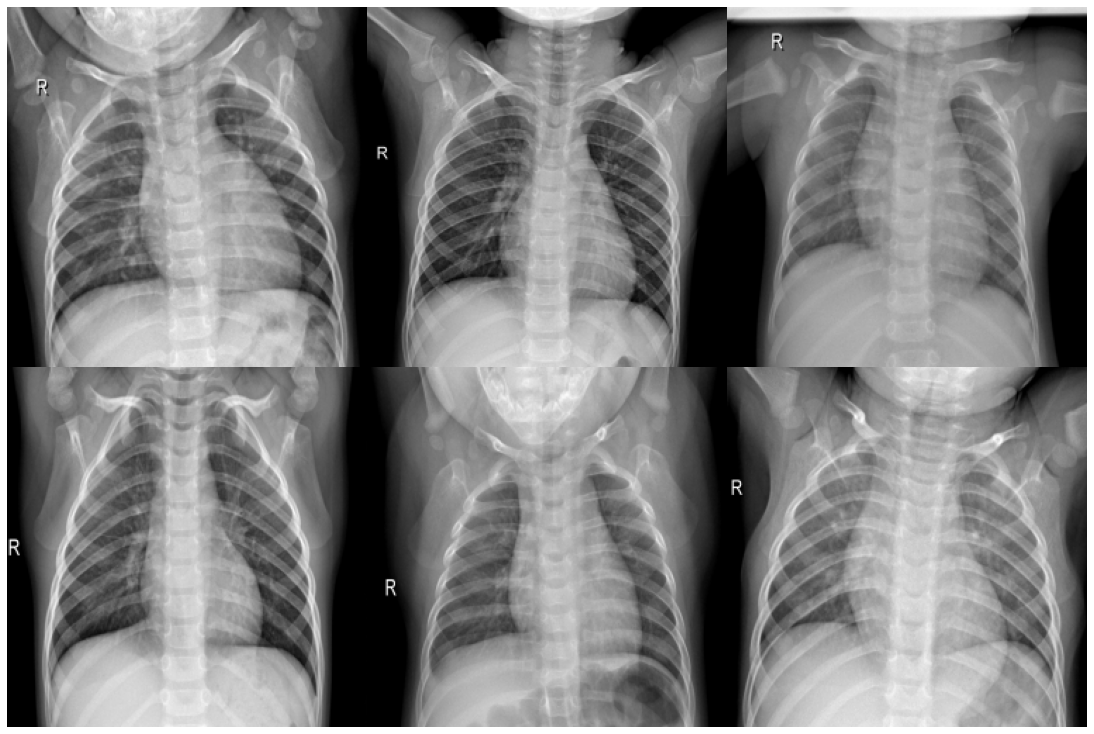

In [8]:
from numpy.random import rand
import matplotlib.pyplot as plt

index = np.random.choice(np.array(gen_n).shape[0], 6, replace=False)
raw_n = np.array(raw_n)
x = raw_n[index]

a, b = 2, 3
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}outputs".format(ROOT_DIR), "beforegan_normal"), dpi=300)
plt.show()

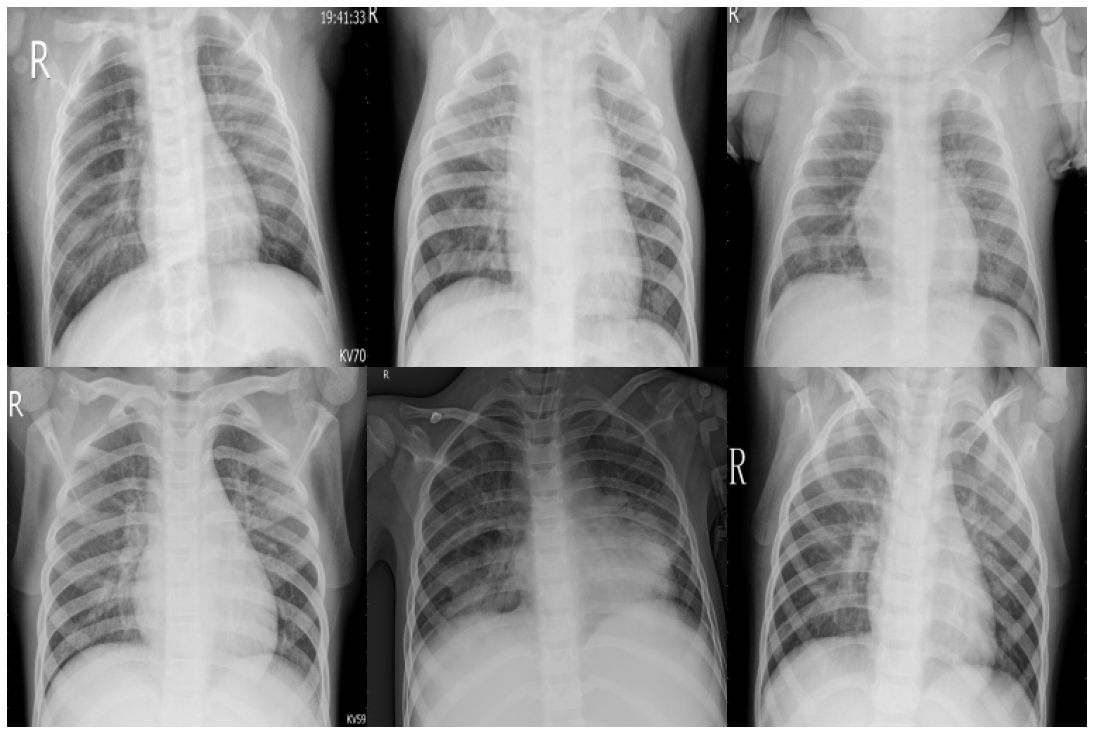

In [9]:
from numpy.random import rand
import matplotlib.pyplot as plt

index = np.random.choice(np.array(gen_p).shape[0], 6, replace=False)
raw_p = np.array(raw_p)
x = raw_p[index]

a, b = 2, 3
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}outputs".format(ROOT_DIR), "beforegan_pneumonia"), dpi=300)
plt.show()

### Synthesize data

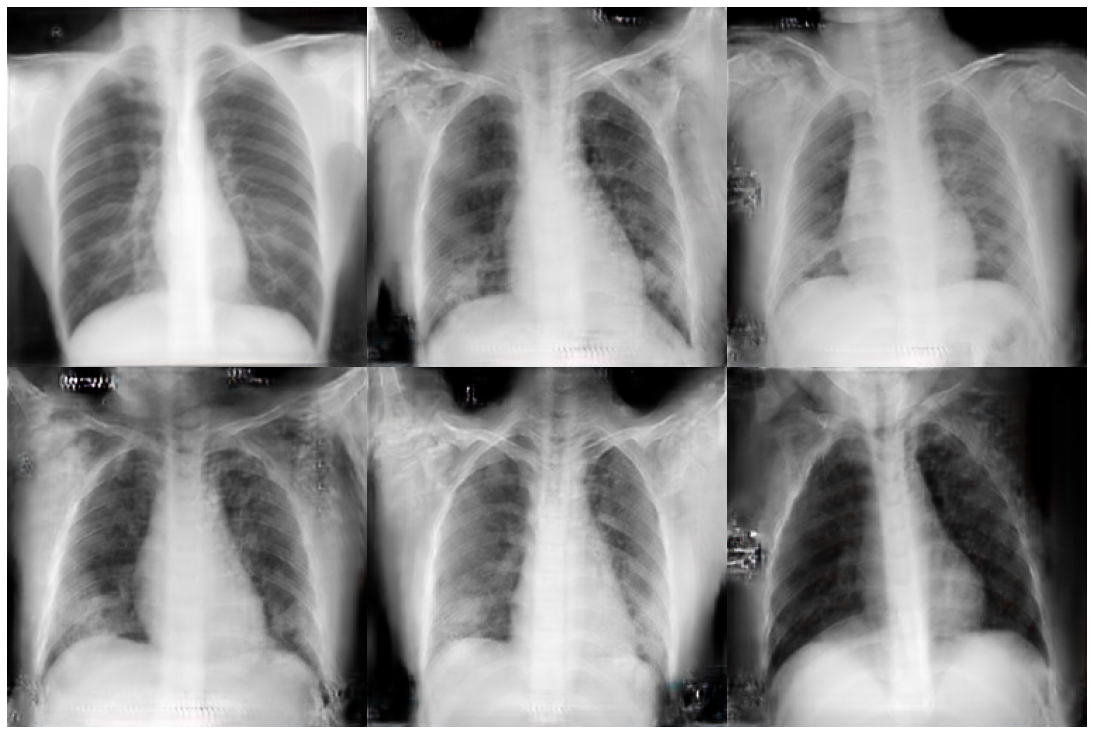

In [10]:
from numpy.random import rand
import matplotlib.pyplot as plt

gen_n = np.array(gen_n)
x = gen_n[index]

a, b = 2, 3
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}outputs".format(ROOT_DIR), "aftergan_normal"), dpi=300)
plt.show()

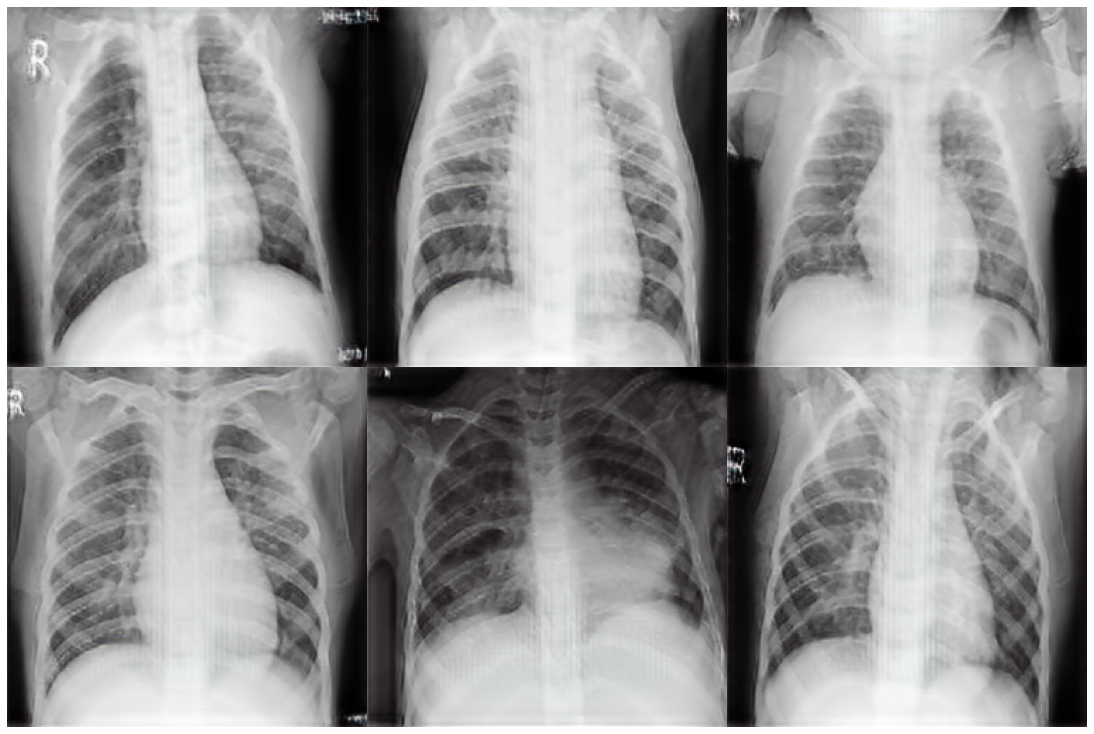

In [11]:
from numpy.random import rand
import matplotlib.pyplot as plt

gen_p = np.array(gen_p)
x = gen_p[index]

a, b = 2, 3
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.png'.format("{}outputs".format(ROOT_DIR), "aftergan_pneumonia"), dpi=300)
plt.show()

In [12]:
x_new.shape, y_new.shape

((3219, 256, 256, 3), (3219, 3))

In [0]:
# # Create directory
# helpers.create_directory("{}/dataset/isic2016gan/".format(ROOT_DIR))

# Save
np.save("{}/dataset/dataNumpy/{}{}.npy".format(ROOT_DIR, "x_", "upsampled"), x_new)
np.save("{}/dataset/dataNumpy/{}{}.npy".format(ROOT_DIR, "y_", "upsampled"), y_new)

In [14]:
print("Done!")

Done!
